## Example with CNN-LSTM on live BTC close price using the full data

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Mounted at /content/drive


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.9 MB/s 
     |████████████████████████████████| 70 kB 9.3 MB/s 
     |████████████████████████████████| 112 kB 57.4 MB/s 
     |████████████████████████████████| 1.1 MB 83.4 MB/s 
     |████████████████████████████████| 45 kB 3.7 MB/s 
     |████████████████████████████████| 288 kB 86.4 MB/s 
     |████████████████████████████████| 144 kB 93.8 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 271 kB 80.0 MB/s 
     |████████████████████████████████| 749 kB 61.8 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2


In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (168726, 8)


### Generate Candles and build features from technical analysis

In [5]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()

# Generate normalized timeseries

In [6]:
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 10000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()

ts_btc.x_candles
ts_btc.x_time
ts_btc.y[-10:]

Candles Normalized
Extracted last 10000 steps
Generated time-series
Normalized 'candles_norm' with shape : (10000, 9)
Feature data 'x_candles' with size : 9952
Feature data with time intervals 'x_time' with size : 9952


[0.36108548094126003,
 0.36234613931340287,
 0.36164379071577835,
 0.362058881104237,
 0.36525386614951094,
 0.36718263886043623,
 0.3671381161142296,
 0.36882979837296226,
 0.36746780295270487,
 0.3673091963598786]

## Train CNN-LSTM model using full data set

In [7]:
btc_model =  s2m.ModelTimeSeries(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, split_fraction = 0.0)
btc_model.sats2model()

In [8]:
model_name = "model/LSTM_CNN_model"
btc_model.sats2train(model_name, epochs=10)

Epoch 1/10
3/3 [==============================] - 25s 2s/step - loss: 0.4448 - val_loss: 0.1338
Epoch 2/10
3/3 [==============================] - 0s 154ms/step - loss: 0.1356 - val_loss: 0.0472
Epoch 3/10
3/3 [==============================] - 0s 161ms/step - loss: 0.0722 - val_loss: 0.1141
Epoch 4/10
3/3 [==============================] - 0s 107ms/step - loss: 0.0852 - val_loss: 0.0628
Epoch 5/10
3/3 [==============================] - 0s 105ms/step - loss: 0.0725 - val_loss: 0.0337
Epoch 6/10
3/3 [==============================] - 0s 151ms/step - loss: 0.0438 - val_loss: 0.0625
Epoch 7/10
3/3 [==============================] - 0s 107ms/step - loss: 0.0525 - val_loss: 0.0374
Epoch 8/10
3/3 [==============================] - 0s 106ms/step - loss: 0.0443 - val_loss: 0.0339
Epoch 9/10
3/3 [==============================] - 0s 162ms/step - loss: 0.0358 - val_loss: 0.0436
Epoch 10/10
3/3 [==============================] - 0s 106ms/step - loss: 0.0403 - val_loss: 0.0313


INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


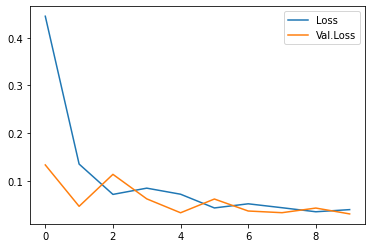

In [9]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [13]:
btc_model.sats2pred(predict_on_test = False)
btc_model.preds

array([[0.5094546 ],
       [0.50974524],
       [0.510008  ],
       ...,
       [0.4342184 ],
       [0.43462726],
       [0.434995  ]], dtype=float32)

In [ ]:
loaded_model =  s2m.ModelTimeSeries(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, split_fraction = 0.0)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.train_test_split()
loaded_model.sats2pred()
loaded_model.preds

In [ ]:
true_vals = ts_btc.denorm(ts_btc.candles_norm[:,-1])
preds = ts_btc.denorm(btc_model.preds)

In [ ]:
plt.plot(preds[0:len(ts_btc.x_candles)-btc_model.split_point], color='orange', label='predictions')
plt.plot(true_vals[btc_model.split_point:len(ts_btc.x_candles)], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [ ]:
plt.plot(preds[-10:], color='orange', label='predictions')
plt.plot(true_vals[-10:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

## Predict the last time step, so should predict following close price

In [ ]:
norm_new_y = btc_model.model.predict([btc_model.x_test_candles[-1:], btc_model.x_test_time[-1:]], batch_size=btc_model.batch_size)
pred_new_y = ts_btc.denorm(norm_new_y)
last_y = ts_btc.denorm(ts_btc.candles_norm[-1:,-1:])
last_y_candle = ts_btc.candles.iloc[-1,-1]
last_y_time = ts_btc.candles.index[-1]

In [ ]:
pred_new_y

In [ ]:
last_y_candle

In [ ]:
last_y_time

## Download new data, generate features and time series

In [ ]:
ldata_df_new = crypto.load_cryptos(tickers,save = False)
new_can_btc = fb.Candles(ldata_df_new,"Bitcoin")
new_can_btc.buildfeatures()
new_ts_btc = c2t.Candle2TimeSeries(new_can_btc.candles, laststeps = 50000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

new_ts_btc.candles2ts()

In [ ]:
last_new_y_time = new_ts_btc.candles.index[-1]
last_new_y_times = new_ts_btc.candles.index [ new_ts_btc.candles.index >= last_y_time ]
new_time_steps = len(last_new_y_times)
last_new_y_times

In [ ]:
new_ts_btc.x_candles = np.asarray(new_ts_btc.x_candles, dtype=np.float32)
new_ts_btc.x_time = np.asarray(new_ts_btc.x_time, dtype=np.float32)

norm_new_y = btc_model.model.predict([new_ts_btc.x_candles[-new_time_steps:], new_ts_btc.x_time[-new_time_steps:]], batch_size=btc_model.batch_size)
pred_new_y = ts_btc.denorm(norm_new_y)
true_last_y = ts_btc.denorm(ts_btc.candles_norm[-new_time_steps:,-1])
new_y_candles = ts_btc.candles.iloc[-new_time_steps:,-1]

In [ ]:
plt.plot(pred_new_y, color='orange', label='predictions')
plt.plot(true_last_y, color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()